In [18]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import time

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 2
BATCH_SIZE = 128
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # default GPU device
GRAYSCALE = False

In [19]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet101(num_classes, grayscale):
    """Constructs a ResNet-101 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 23, 3],
                   num_classes=2,
                   grayscale=grayscale)
    return model


In [20]:
torch.manual_seed(1)
GRAYSCALE=False

##########################
### COST AND OPTIMIZER
##########################

model = resnet101(2, GRAYSCALE)


In [21]:

model.load_state_dict(torch.load('/home/constanza/tfg/TFG/thesis/model_attractiveness.pth'))
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Attractive'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [23]:
custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])
test_dataset = CelebaDataset(csv_path='celeba-attractiveness-test.csv',
                             img_dir='img_align_celeba/',
                             transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=10000,
                         shuffle=False,
                         num_workers=4)

In [ ]:
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[6], (1, 2, 0)))

In [ ]:
model.eval()
logits, probas = model(features.to(DEVICE)[6, None])
print('Probability NO Attractiveness %.2f%%' % (probas[0][0]*100))

In [9]:
df = pd.read_csv('parsed_files/celeba-attractiveness-test.csv')

segunda_columna = df.iloc[:, 1].values

print(segunda_columna[0])

0


In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc

j = 0 
tp = 0
tn = 0
fp = 0
fn = 0

df_tp = pd.DataFrame(columns=['Images correctly Attractive Classified'])
df_tn = pd.DataFrame(columns=['Images correctly Not Attractive Classified'])
df_performance_model = pd.DataFrame(columns=['Type Model Evaluation','Accuracy','True positive','True negative','False positive','False negative','Precision','Recall','F1 Score'])

y_true = segunda_columna  # Ground truth labels
y_scores = []  # Probabilities of prediction

for i in range(10): 
    logits, probas = model(features.to(DEVICE)[i, None])
    y_scores.append(probas[0][0])  # Save probabilities for ROC calculation
    
    prediction = probas[0][0] > 0.5  # Using 0.5 as the decision threshold
    print(prediction)
    if prediction == y_true[i]:
        if prediction == 1:
            df_tp = df_tp.append({'Images correctly Attractive Classified': df.iloc[i, 0]}, ignore_index=True)        
            tp += 1
        else:
            df_tn = df_tn.append({'Images correctly Not Attractive Classified': df.iloc[i, 0]}, ignore_index=True)        
            tn += 1
    else:
        if prediction == 1:
            fp += 1
        else:
            fn += 1

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Save results to a DataFrame
new_row_values = ['TOTAL performance Model', accuracy, tp, tn, fp, fn, precision, recall, f1]

print("Accuracy of the model:", accuracy)
print("True positive:", tp)
print("True negative:", tn)
print("False positive:", fp)
print("False negative:", fn)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.savefig('ROC_curve.png', dpi=300)
plt.show()


tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.83 GiB. GPU 0 has a total capacity of 15.72 GiB of which 1.50 GiB is free. Including non-PyTorch memory, this process has 13.48 GiB memory in use. Of the allocated memory 13.26 GiB is allocated by PyTorch, and 21.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
print(new_row_values)
df_performance_model.loc[len(df_performance_model)] = new_row_values
df_performance_model.head()


['TOTAL performance Model', 0.7312, 2533, 4779, 232, 2456, 0.9160940325497288, 0.5077169773501704, 0.65334021150374]


,Type Model Evaluation,Accuracy,True positive,True negative,False positive,False negative,Precission,Recall,F1 Score
0,TOTAL performance Model,0.7312,2533,4779,232,2456,0.916094,0.507717,0.65334
1,TOTAL performance Model,0.7312,2533,4779,232,2456,0.916094,0.507717,0.65334


In [11]:
df_performance_model.head()

NameError: name 'df_performance_model' is not defined

In [13]:
test_dataset_fem = CelebaDataset(csv_path='parsed_files/celeba-att-female-test.csv',
                             img_dir='img_align_celeba/',
                             transform=custom_transform)

test_loader_fem = DataLoader(dataset=test_dataset_fem,
                         batch_size=10000,
                         shuffle=False,
                         num_workers=4)

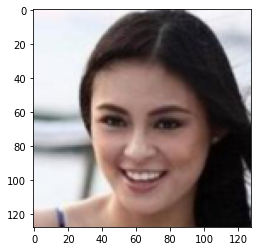

In [14]:
for batch_idx_f, (features_f, targets_f) in enumerate(test_loader_fem):
    features_f = features_f
    targets_f = targets_f
    break
    
plt.imshow(np.transpose(features_f[4569], (1, 2, 0)))

In [15]:
df_f = pd.read_csv('parsed_files/celeba-att-female-test.csv')

segunda_columna_f = df_f.iloc[:, 1].values
print(segunda_columna_f[4569])

1


In [37]:
j=0
tp_f = 0
tn_f = 0
fp_f = 0
fn_f = 0
df_f_tp = pd.DataFrame(columns=['Female Images correctly Attractive Classified'])
df_f_tn = pd.DataFrame(columns=['Female Images correctly Not Attractive Classified'])

for i in range(10000): 
    logits, probas = model(features_f.to(DEVICE)[i, None])
    if(probas[0][0]*100)>50 and segunda_columna_f[i]==0:
        df_f_tn = df_f_tn.append({'Female Images correctly Not Attractive Classified': df_f.iloc[i, 0]}, ignore_index=True)        
        j=j+1
        tn_f = tn_f+1
    if(probas[0][0]*100)<50 and segunda_columna_f[i]==1:
        df_f_tp = df_f_tp.append({'Female Images correctly Attractive Classified': df_f.iloc[i, 0]}, ignore_index=True)
        j=j+1
        tp_f = tp_f+1
    if(probas[0][0]*100)<50 and segunda_columna_f[i]==0:
        fp_f = fp_f+1
    if(probas[0][0]*100)>50 and segunda_columna_f[i]==1:
        fn_f = fn_f+1
        

print(j/2000)

df_f_tp.to_csv('correctly_attractive_female.csv', index=False)
df_f_tn.to_csv('correctly_UNattractive_female.csv', index=False)
accuracy_f = (tp_f+tn_f)/(tp_f+tn_f+fp_f+fn_f)
print(tp_f+tn_f+fp_f+fn_f)
precission_f = tp_f/(tp_f+fp_f)
recall_f = tp_f/(tp_f+fn_f)
f1_f = 2* (precission_f*recall_f)/(precission_f + recall_f)
new_row_values_f = ['FEMALE performance Model',accuracy_f,tp_f,tn_f,fp_f,fn_f,precission_f,recall_f,f1_f]
print("Accuracy of the model: ",accuracy_f)
print("True positive: ", tp_f)
print("True negative: ", tn_f)
print("False positive: ", fp_f)
print("False negative: ", fn_f)
print("Precicion: ", precission_f)
print("Recall: ", recall_f)

3.461
10000
Accuracy of the model:  0.6922
True positive:  3697
True negative:  3225
False positive:  274
False negative:  2804
Precicion:  0.9309997481742635
Recall:  0.5686817412705738


In [38]:
df_performance_model.loc[len(df_performance_model)] = new_row_values_f
df_performance_model.head()


,Type Model Evaluation,Accuracy,True positive,True negative,False positive,False negative,Precission,Recall,F1 Score
0,TOTAL performance Model,0.7312,2533,4779,232,2456,0.916094,0.507717,0.653340
1,FEMALE performance Model,0.6922,3697,3225,274,2804,0.931000,0.568682,0.706073


In [16]:
test_dataset_m = CelebaDataset(csv_path='parsed_files/celeba-att-male-test.csv',
                             img_dir='img_align_celeba/',
                             transform=custom_transform)

test_loader_m = DataLoader(dataset=test_dataset_m,
                         batch_size=7100,
                         shuffle=False,
                         num_workers=4)

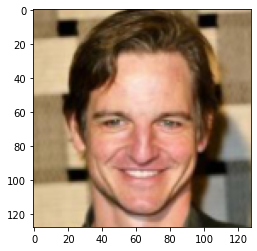

In [17]:
for batch_idx_m, (features_m, targets_m) in enumerate(test_loader_m):
    features_m = features_m
    targets_m = targets_m
    break
    
plt.imshow(np.transpose(features_m[300], (1, 2, 0)))

In [18]:
df_m = pd.read_csv('parsed_files/celeba-att-male-test.csv')

# Extraemos los valores de la segunda columna en un vector
segunda_columna_m = df_m.iloc[:, 1].values

In [46]:
j=0
tp_m = 0
tn_m = 0
fp_m = 0
fn_m = 0
df_m_tp = pd.DataFrame(columns=['Male Images correctly Attractive Classified'])
df_m_tn = pd.DataFrame(columns=['Male Images correctly Not Attractive Classified'])
for i in range(7100): 
    logits, probas = model(features_m.to(DEVICE)[i, None])
    if(probas[0][0]*100)>50 and segunda_columna_m[i]==0:
        df_m_tn = df_m_tn.append({'Male Images correctly Not Attractive Classified': df_m.iloc[i, 0]}, ignore_index=True)        
        tn_m=tn_m+1
    if(probas[0][0]*100)<50 and segunda_columna_m[i]==1:
        df_m_tp = df_m_tp.append({'Male Images correctly Attractive Classified': df_m.iloc[i, 0]}, ignore_index=True)        
        tp_m=tp_m+1
    if(probas[0][0]*100)<50 and segunda_columna_m[i]==0:
        fp_m = fp_m+1
    if(probas[0][0]*100)>50 and segunda_columna_m[i]==1:
        fn_m = fn_m+1

print(j/7100)
df_m_tp.to_csv('correctly_attractive_male.csv', index=False)
df_m_tn.to_csv('correctly_UNattractive_male.csv', index=False)
accuracy_m = (tp_m+tn_m)/(tp_m+tn_m+fp_m+fn_m)
print(tp_m+tn_m+fp_m+fn_m)
precission_m = tp_m/(tp_m+fp_m)
recall_m = tp_m/(tp_m+fn_m)
f1_m = 2* (precission_m*recall_m)/(precission_m + recall_m)
new_row_values_m = ['MALE performance Model',accuracy_m,tp_m,tn_m,fp_m,fn_m,precission_m,recall_m,f1_m]
print("Accuracy of the model: ",accuracy_m)
print("True positive: ", tp_m)
print("True negative: ", tn_m)
print("False positive: ", fp_m)
print("False negative: ", fn_m)
print("Precicion: ", precission_m)
print("Recall: ", recall_m)


0.0
7100
Accuracy of the model:  0.7970422535211268
True positive:  417
True negative:  5242
False positive:  97
False negative:  1344
Precicion:  0.811284046692607
Recall:  0.23679727427597955


In [47]:
df_performance_model.loc[len(df_performance_model)] = new_row_values_m
df_performance_model.head()

,Type Model Evaluation,Accuracy,True positive,True negative,False positive,False negative,Precission,Recall,F1 Score
0,TOTAL performance Model,0.731200,2533,4779,232,2456,0.916094,0.507717,0.653340
1,FEMALE performance Model,0.692200,3697,3225,274,2804,0.931000,0.568682,0.706073
2,MALE performance Model,0.797042,417,5242,97,1344,0.811284,0.236797,0.366593


In [8]:
df_performance_model.to_csv('parsed_files/performance_test.csv', index=False)


NameError: name 'df_performance_model' is not defined

In [11]:
test_dataset_DPf = CelebaDataset(csv_path='parsed_files/celeba-att-DP-female-test.csv',
                             img_dir='img_align_celeba/',
                             transform=custom_transform)

test_loader_DPf = DataLoader(dataset=test_dataset_DPf,
                         batch_size=1000,
                         shuffle=False,
                         num_workers=4)

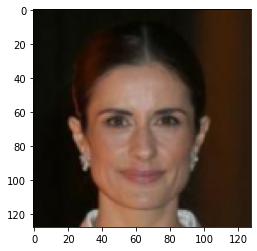

In [12]:
for batch_idx_DPf, (features_DPf, targets_DPf) in enumerate(test_loader_DPf):
    features_DPf = features_DPf
    targets_DPf = targets_DPf
    break
    
plt.imshow(np.transpose(features_DPf[300], (1, 2, 0)))

In [13]:
df_m = pd.read_csv('parsed_files/celeba-att-DP-female-test.csv')

# Extraemos los valores de la segunda columna en un vector
true_labe_DPf = df_m.iloc[:, 1].values

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc

j = 0 
tp = 0
tn = 0
fp = 0
fn = 0
df_performance_model = pd.DataFrame(columns=['Type Model Evaluation','Accuracy','True positive','True negative','False positive','False negative','Precision','Recall','F1 Score'])

y_true = true_labe_DPf  # Ground truth labels
y_scores = []  # Probabilities of prediction

for i in range(1000): 
    logits, probas = model(features_DPf.to(DEVICE)[i, None])
    y_scores.append(1-probas[0][0])  # Save probabilities for ROC calculation
    
    prediction = probas[0][0] > 0.5  # Using 0.5 as the decision threshold
    
    if prediction == y_true[i]:
        if prediction == 1:
            tp += 1
        else:
            tn += 1
    else:
        if prediction == 1:
            fp += 1
        else:
            fn += 1

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Save results to a DataFrame
new_row_values = ['TOTAL performance Model', accuracy, tp, tn, fp, fn, precision, recall, f1]

print("Accuracy of the model:", accuracy)
print("True positive:", tp)
print("True negative:", tn)
print("False positive:", fp)
print("False negative:", fn)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.savefig('ROC_curve.png', dpi=300)
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 15.72 GiB of which 188.81 MiB is free. Including non-PyTorch memory, this process has 14.80 GiB memory in use. Of the allocated memory 14.58 GiB is allocated by PyTorch, and 21.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
test_dataset_DPm = CelebaDataset(csv_path='parsed_files/celeba-att-DP-male-test.csv',
                             img_dir='img_align_celeba/',
                             transform=custom_transform)

test_loader_DPm = DataLoader(dataset=test_dataset_DPm,
                         batch_size=1000,
                         shuffle=False,
                         num_workers=4)